In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

In [26]:
csv_path = "covid_jabar_perkembangan_harian.csv" 
df = pd.read_csv(csv_path)

print("Kolom yang tersedia di dataset:")
print(df.columns)
print("\n5 baris pertama:")
print(df.head())

Kolom yang tersedia di dataset:
Index(['tanggal', 'kode_kab_kota', 'nama_kab_kota', 'konfirmasi_total', 'konfirmasi_sembuh', 'konfirmasi_meninggal',
       'konfirmasi_aktif', 'konfirmasi_total_daily_growth', 'konfirmasi_sembuh_daily_growth',
       'konfirmasi_meninggal_daily_growth', 'konfirmasi_aktif_daily_growth', 'kota_kab_belum_teridentifikasi',
       'sembuh_unidentified', 'meninggal_unidentified', 'id'],
      dtype='object')

5 baris pertama:
               tanggal  kode_kab_kota            nama_kab_kota  konfirmasi_total  konfirmasi_sembuh  \
0  2020-03-01 00:00:00             32               jawa barat               NaN                NaN   
1  2020-03-01 00:00:00           3204        Kabupaten Bandung               0.0                0.0   
2  2020-03-01 00:00:00           3217  Kabupaten Bandung Barat               0.0                0.0   
3  2020-03-01 00:00:00           3216         Kabupaten Bekasi               0.0                0.0   
4  2020-03-01 00:00:00      

In [20]:
df["tanggal"] = pd.to_datetime(df["tanggal"])

# Group by tanggal, jumlahkan semua kasus aktif dari semua kab/kota
df_group = (
    df.groupby("tanggal", as_index=False)["konfirmasi_aktif"]
      .sum()
      .sort_values("tanggal")
      .reset_index(drop=True)
)

print("\n5 baris pertama setelah agregasi per tanggal (total Jabar):")
print(df_group.head())


5 baris pertama setelah agregasi per tanggal (total Jabar):
     tanggal  konfirmasi_aktif
0 2020-03-01               2.0
1 2020-03-02               2.0
2 2020-03-03               1.0
3 2020-03-04               3.0
4 2020-03-05               3.0


In [21]:
df_group = df_group[df_group["konfirmasi_aktif"].notna()].copy()
df_group = df_group.reset_index(drop=True)

# Coba ambil hanya yang > 0
df_nonzero = df_group[df_group["konfirmasi_aktif"] > 0].copy()

if len(df_nonzero) < 2:
    print("\nPeringatan: Data dengan konfirmasi_aktif > 0 kurang dari 2 baris.")
    print("Dipakai semua data non-NaN sebagai fallback.")
    df_nonzero = df_group.copy()

df_nonzero = df_nonzero.reset_index(drop=True)

print("\nJumlah baris df_nonzero (dipakai untuk simulasi):", len(df_nonzero))
print(df_nonzero.head())

if len(df_nonzero) == 0:
    raise ValueError("Tidak ada data yang bisa dipakai (df_nonzero kosong). Cek lagi nama kolom dan isi CSV.")


Jumlah baris df_nonzero (dipakai untuk simulasi): 1046
     tanggal  konfirmasi_aktif
0 2020-03-01               2.0
1 2020-03-02               2.0
2 2020-03-03               1.0
3 2020-03-04               3.0
4 2020-03-05               3.0


In [22]:
h = 1.0  # langkah waktu (1 hari)

# Nilai awal I0 dari baris pertama data yang dipakai
I0 = float(df_nonzero["konfirmasi_aktif"].iloc[0])

# Default r kalau tidak bisa estimasi
r_est = 0.1

if len(df_nonzero) >= 2:
    I1 = float(df_nonzero["konfirmasi_aktif"].iloc[1])
    if I0 > 0 and I1 > 0:
        r_est = np.log(I1 / I0) / h

print("\n=== PARAMETER MODEL ===")
print("I0 (hari pertama untuk simulasi):", I0)
if len(df_nonzero) >= 2:
    print("I1 (hari kedua untuk simulasi):", float(df_nonzero['konfirmasi_aktif'].iloc[1]))
print("Estimasi r (per hari):", r_est)


=== PARAMETER MODEL ===
I0 (hari pertama untuk simulasi): 2.0
I1 (hari kedua untuk simulasi): 2.0
Estimasi r (per hari): 0.0


In [23]:
def f(t, I, r):
    """Model ODE sederhana: dI/dt = r * I"""
    return r * I


def rk4_step(f, t, y, h, r):
    """
    Satu langkah metode Runge-Kutta orde 4 untuk ODE 1 dimensi.
    f : fungsi ODE f(t, y, r)
    t : waktu sekarang
    y : nilai sekarang
    h : langkah waktu
    r : parameter laju
    """
    k1 = f(t, y, r)
    k2 = f(t + 0.5 * h, y + 0.5 * h * k1, r)
    k3 = f(t + 0.5 * h, y + 0.5 * h * k2, r)
    k4 = f(t + h,         y + h * k3,     r)
    return y + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)


# Contoh satu langkah dari I0
t0 = 0.0
I_next_example = rk4_step(f, t0, I0, h, r_est)
print("\nContoh satu langkah RK4 dari I0 ke hari berikutnya:", I_next_example)


Contoh satu langkah RK4 dari I0 ke hari berikutnya: 2.0


In [24]:
n_days = len(df_nonzero)
t_values = np.arange(n_days) * h  # t = 0,1,2,...

I_model = np.zeros(n_days)
I_model[0] = I0

for n in range(n_days - 1):
    I_model[n + 1] = rk4_step(f, t_values[n], I_model[n], h, r_est)

df_nonzero["I_model_rk4"] = I_model

print("\n5 baris pertama data vs model:")
print(df_nonzero[["tanggal", "konfirmasi_aktif", "I_model_rk4"]].head())


5 baris pertama data vs model:
     tanggal  konfirmasi_aktif  I_model_rk4
0 2020-03-01               2.0          2.0
1 2020-03-02               2.0          2.0
2 2020-03-03               1.0          2.0
3 2020-03-04               3.0          2.0
4 2020-03-05               3.0          2.0


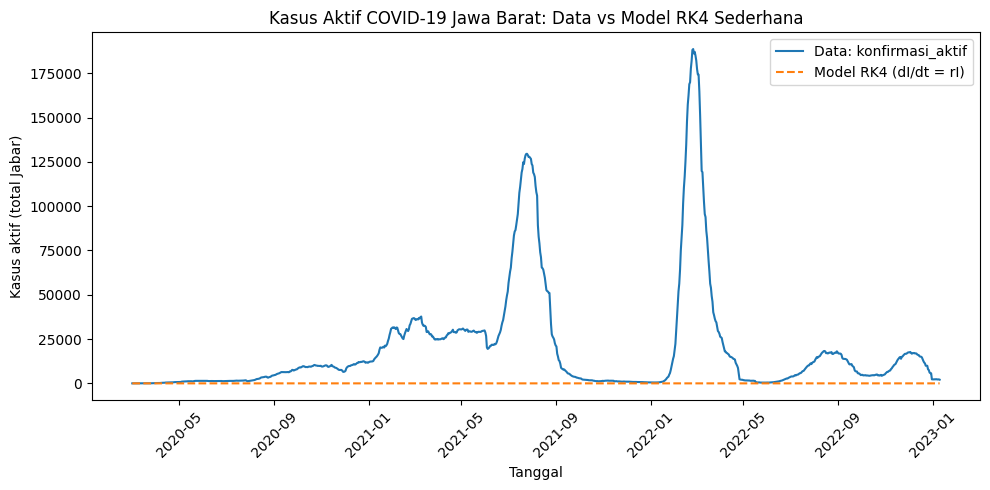

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(df_nonzero["tanggal"], df_nonzero["konfirmasi_aktif"], label="Data: konfirmasi_aktif")
plt.plot(df_nonzero["tanggal"], df_nonzero["I_model_rk4"], linestyle="--", label="Model RK4 (dI/dt = rI)")
plt.xlabel("Tanggal")
plt.ylabel("Kasus aktif (total Jabar)")
plt.title("Kasus Aktif COVID-19 Jawa Barat: Data vs Model RK4 Sederhana")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

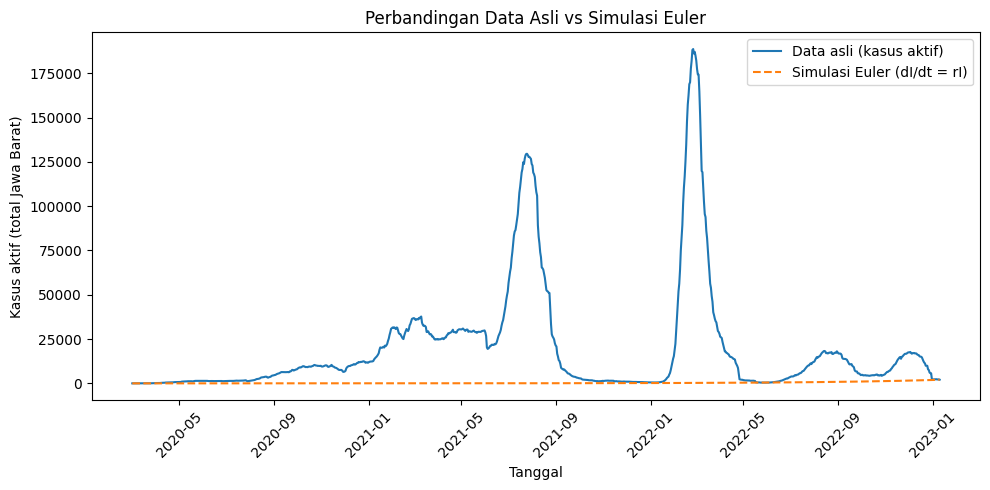

In [31]:
# 8. Plot data vs hasil simulasi Euler

plt.figure(figsize=(10, 5))
plt.plot(df_result["tanggal"], df_result["I_data"], label="Data asli (kasus aktif)")
plt.plot(df_result["tanggal"], df_result["I_euler"], "--", label="Simulasi Euler (dI/dt = rI)")
plt.xlabel("Tanggal")
plt.ylabel("Kasus aktif (total Jawa Barat)")
plt.title("Perbandingan Data Asli vs Simulasi Euler")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
# 9. Menghitung error antara data dan simulasi (MSE dan MAE)

diff = df_result["I_euler"].values - df_result["I_data"].values
mse = np.mean(diff**2)
mae = np.mean(np.abs(diff))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 1424191739.0097108
Mean Absolute Error (MAE): 19268.165123765815
